<a href="https://colab.research.google.com/github/alirezakhaleghianaghizi/Deep-generative-models/blob/main/DGM_HW2_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [2]:
name = 'alireza khaleghi anaghizi'
std_id = '99101462'

In [3]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [4]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [5]:
# TODO: Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Merge the two datasets to train the model on the images.

In [6]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset([train_dataset, test_dataset])
merged_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [7]:
def plot_class_distribution(dataloader):
    # TODO: Initialize a dictionary to count occurrences of each class
    class_counts = {i: 0 for i in range(10)}
    # TODO: Iterate through the DataLoader to count the labels
    for images, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1
    # TODO: Plot the histogram
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in the Merged Dataset')
    plt.show()

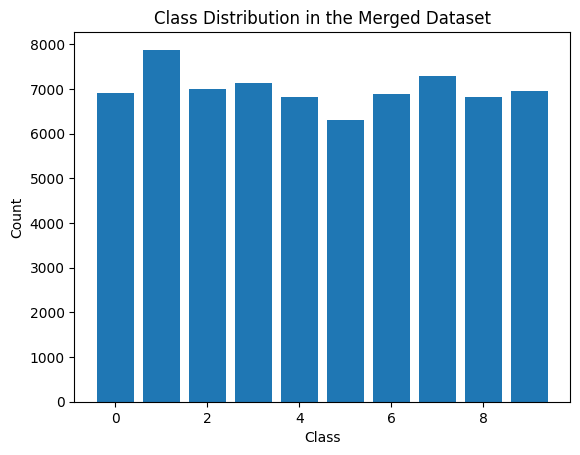

In [8]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [9]:
def plot_class_averages(dataloader):
    # TODO: Iterate over the DataLoader to accumulate sums and counts
    class_sums = {i: torch.zeros(28, 28) for i in range(10)}
    class_counts = {i: 0 for i in range(10)}

    for images, labels in dataloader:
        for i, label in enumerate(labels):
            class_sums[label.item()] += images[i][0]
            class_counts[label.item()] += 1
    # TODO: Calculate the average images for each class
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i in range(10):
        avg_image = class_sums[i] / class_counts[i]
        ax = axes[i // 5, i % 5]
        ax.imshow(avg_image, cmap='gray')
        ax.set_title(f'Class {i}')
        ax.axis('off')
    # TODO: Plot the averages
    plt.suptitle('Average Image of Each Class')
    plt.show()

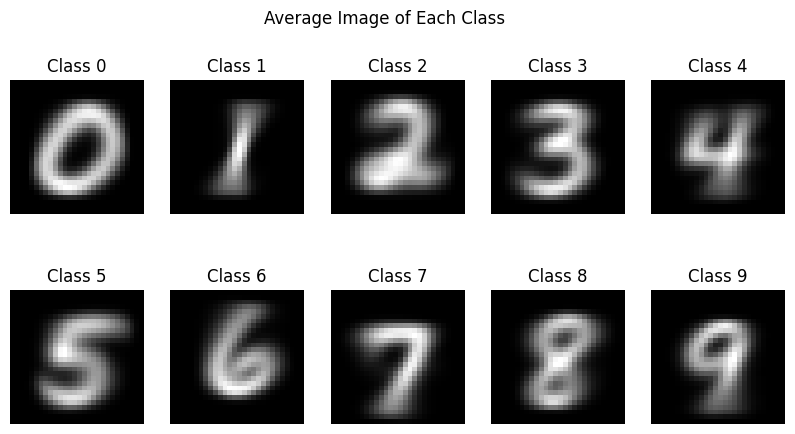

In [10]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [11]:
class VAE(nn.Module):

    def __init__(self, latent_dim=2):
        # TODO
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        # TODO
        x = x.view(-1, 28*28)
        mean_var = self.encoder(x)
        mean = mean_var[:, :self.latent_dim]
        log_var = mean_var[:, self.latent_dim:]
        return mean, log_var

    def reparameterization(self, mean, var):
        # TODO
        std = torch.exp(0.5 * var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def decode(self, x):
        # TODO
        x_hat = self.decoder(x)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        # TODO
        mean, var = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        return x_hat, mean, var

In [26]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [27]:
def loss_function(x, x_hat, mean, log_var):
    # TODO
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss

Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [28]:
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()


def train(model, optimizer, n_epochs=50, losses=losses):
    model.train()
    losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for images, _ in merged_loader:
            images = images.to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var = model(images)
            loss = loss_function(images, x_hat, mean, log_var)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(merged_loader.dataset)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')

    return losses

In [29]:
losses += train(model, optimizer)

Epoch [1/50], Loss: 176.4017
Epoch [2/50], Loss: 153.3034
Epoch [3/50], Loss: 148.0308
Epoch [4/50], Loss: 145.5041
Epoch [5/50], Loss: 143.9083
Epoch [6/50], Loss: 143.3953
Epoch [7/50], Loss: 142.3185
Epoch [8/50], Loss: 142.5660
Epoch [9/50], Loss: 141.6642
Epoch [10/50], Loss: 140.6904
Epoch [11/50], Loss: 140.0456
Epoch [12/50], Loss: 140.2116
Epoch [13/50], Loss: 139.6676
Epoch [14/50], Loss: 138.7266
Epoch [15/50], Loss: 139.0635
Epoch [16/50], Loss: 138.5560
Epoch [17/50], Loss: 138.5969
Epoch [18/50], Loss: 138.6849
Epoch [19/50], Loss: 138.5702
Epoch [20/50], Loss: 138.9741
Epoch [21/50], Loss: 138.4431
Epoch [22/50], Loss: 138.0981
Epoch [23/50], Loss: 138.5299
Epoch [24/50], Loss: 137.5205
Epoch [25/50], Loss: 138.6063
Epoch [26/50], Loss: 138.0958
Epoch [27/50], Loss: 137.5406
Epoch [28/50], Loss: 138.2046
Epoch [29/50], Loss: 137.4279
Epoch [30/50], Loss: 137.0395
Epoch [31/50], Loss: 136.7011
Epoch [32/50], Loss: 137.4821
Epoch [33/50], Loss: 138.2795
Epoch [34/50], Loss

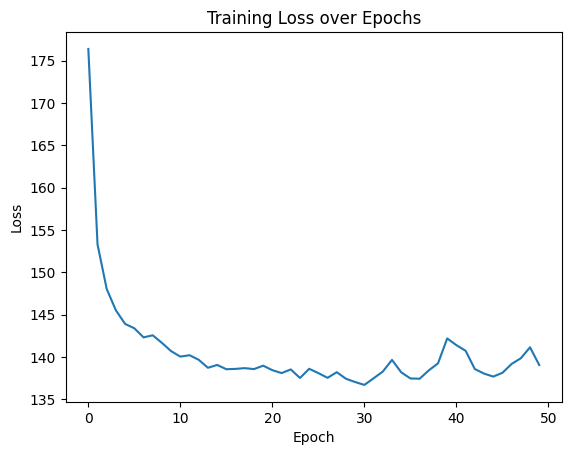

In [30]:
plot_losses(losses)

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

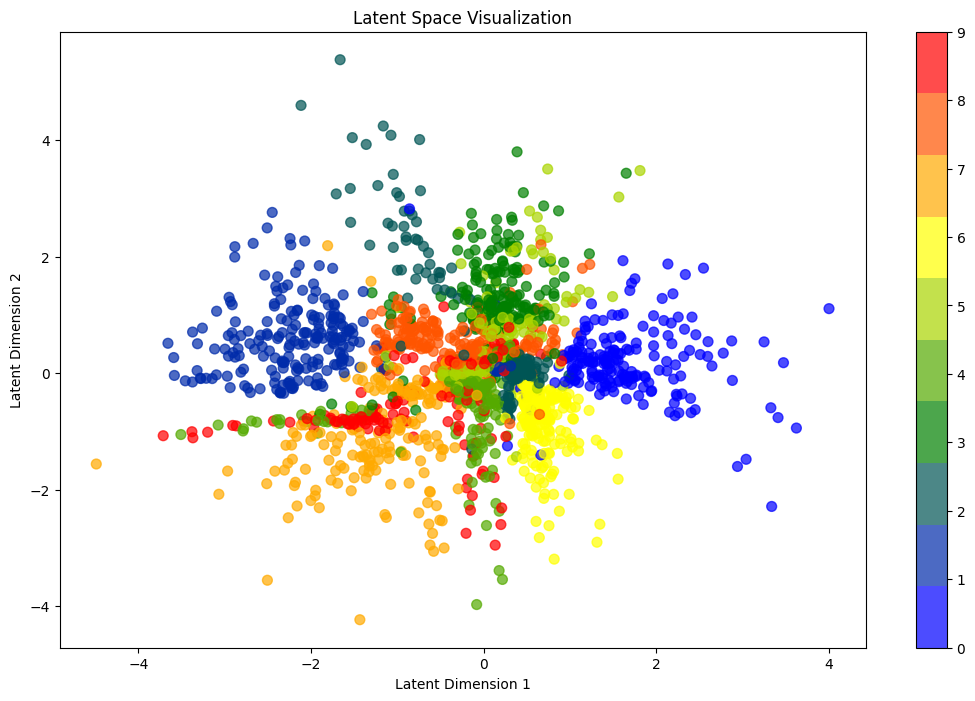

In [31]:
import matplotlib.colors as mcolors
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the dataloader and plot the latent space
    vae.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for i, (images, label) in enumerate(dataloader):
            if i > batch_count:
                break
            images = images.to(device)
            mean, _ = vae.encode(images)
            latents.append(mean.cpu().numpy())
            labels.append(label.numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    plt.figure(figsize=(13, 8))
    cmap = mcolors.LinearSegmentedColormap.from_list("blue_green_yellow_red", ["blue", "green", "yellow", "red"], N=10)

    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=cmap,alpha = 0.7,s=50)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

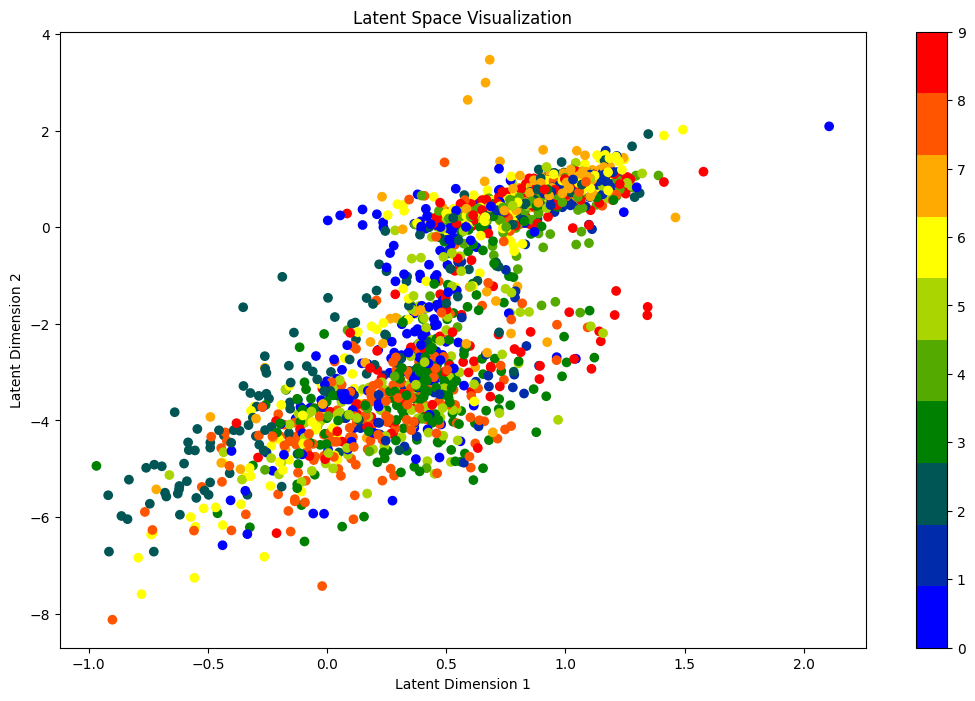

In [33]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    vae.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for i, (images, label) in enumerate(dataloader):
            if i > batch_count:
                break
            inverted_images = 1 - images.to(device)
            mean, _ = vae.encode(inverted_images)
            latents.append(mean.cpu().numpy())
            labels.append(label.numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    cmap = mcolors.LinearSegmentedColormap.from_list("blue_green_yellow_red", ["blue", "green", "yellow", "red"], N=10)

    plt.figure(figsize=(13, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap=cmap)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

تشخیص ناهنجاری با استفاده از فضای نهان VAE

ایده اصلی استفاده از فضای نهان یک VAE برای تشخیص ناهنجاری این است که VAE برای فشرده‌سازی داده‌ها از یک توزیع خاص (در این مورد، تصاویر اعداد MNIST) به یک فضای نهان ساختار یافته آموزش دیده است. اگر داده‌هایی که توزیع مشابهی ندارند (مانند تصاویر معکوس شده) معرفی شوند، VAE همچنان سعی می‌کند این ورودی‌ها را کدگذاری کند، اما نمایه‌های نهان آن‌ها احتمالاً از توزیع داده‌های اصلی در فضای نهان منحرف خواهد شد.

1. انحراف فضای نهان:

   • داده‌های نرمال (اعداد) در یک منطقه خاص از فضای نهان فشرده می‌شوند. زمانی که داده‌های غیرعادی یا خارج از توزیع (OOD) (مانند تصاویر معکوس شده یا داده‌های نویزی) به کدگذار وارد می‌شوند، نمایه‌های نهانی آن‌ها به طور قابل توجهی از منطقه فشرده داده‌های نرمال منحرف می‌شوند.

   • با شناسایی چنین انحرافاتی، می‌توانیم ناهنجاری‌ها را تشخیص دهیم. اگر نمایه نهانی یک نمونه از فضای نهان نرمال فاصله زیادی داشته باشد، نشان‌دهنده این است که ورودی با توزیع اصلی داده‌ها مطابقت ندارد.

2. خطای بازسازی:

   • برای تشخیص ناهنجاری مبتنی بر VAE، می‌توان خطای بازسازی را نیز مورد بررسی قرار داد. اگر داده ورودی از توزیع آموزشی فاصله زیادی داشته باشد، مدل در بازسازی آن دچار مشکل خواهد شد. خطای بالای بازسازی می‌تواند نشانه‌ای از وجود ناهنجاری باشد.


اگر به جای VAE از یک Autoencoder معمولی استفاده کنیم، مشاهدات متفاوت خواهد بود:

• Autoencoder:

  • در یک Autoencoder، تمرکز اصلی بر روی حداقل کردن خطای بازسازی به طور مستقیم است، بدون اینکه فضای نهان را منظم کند (همانطور که در VAE انجام می‌شود). برای داده‌های نرمال، خطای بازسازی پایین خواهد بود، اما برای داده‌های غیرعادی یا خارج از توزیع، خطای بازسازی به طور قابل توجهی بالاتر خواهد بود.

  • تشخیص ناهنجاری با استفاده از Autoencoder عمدتاً به خطای بازسازی بستگی دارد؛ اگر این خطا از آستانه مشخصی فراتر رود، ورودی احتمالاً غیرعادی است.

• VAE:

  • یک VAE فضای نهان را منظم می‌کند و آن را مجبور به پیروی از توزیع گاوسی می‌کند. نقاط داده غیرعادی یا با فاصله در فضای نهان از توزیع نرمال شناسایی می‌شوند یا از طریق خطای بازسازی. مزیت VAE این است که می‌توانید از هر دو انحراف فضای نهان و خطای بازسازی برای تشخیص ناهنجاری استفاده کنید.

در خلاصه، Autoencoder بیشتر بر روی خطای بازسازی تمرکز دارد، در حالی که VAEs مجموعه‌ای غنی‌تر از ابزارها را با ترکیب ساختار فضای نهان و کیفیت بازسازی ارائه می‌دهند.

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [35]:
def generate_digit(mean, var):
    # TODO: Return the generated image
    eps = torch.randn_like(mean)
    z = mean + eps * var.sqrt()
    generated_image = model.decode(z)
    return generated_image

Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [36]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid

    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    # TODO: Generate images for the grid

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            generated_image = model.decode(z_sample)
            generated_image = generated_image.view(digit_size, digit_size).cpu().detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = generated_image

    # TODO: Display the results

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()

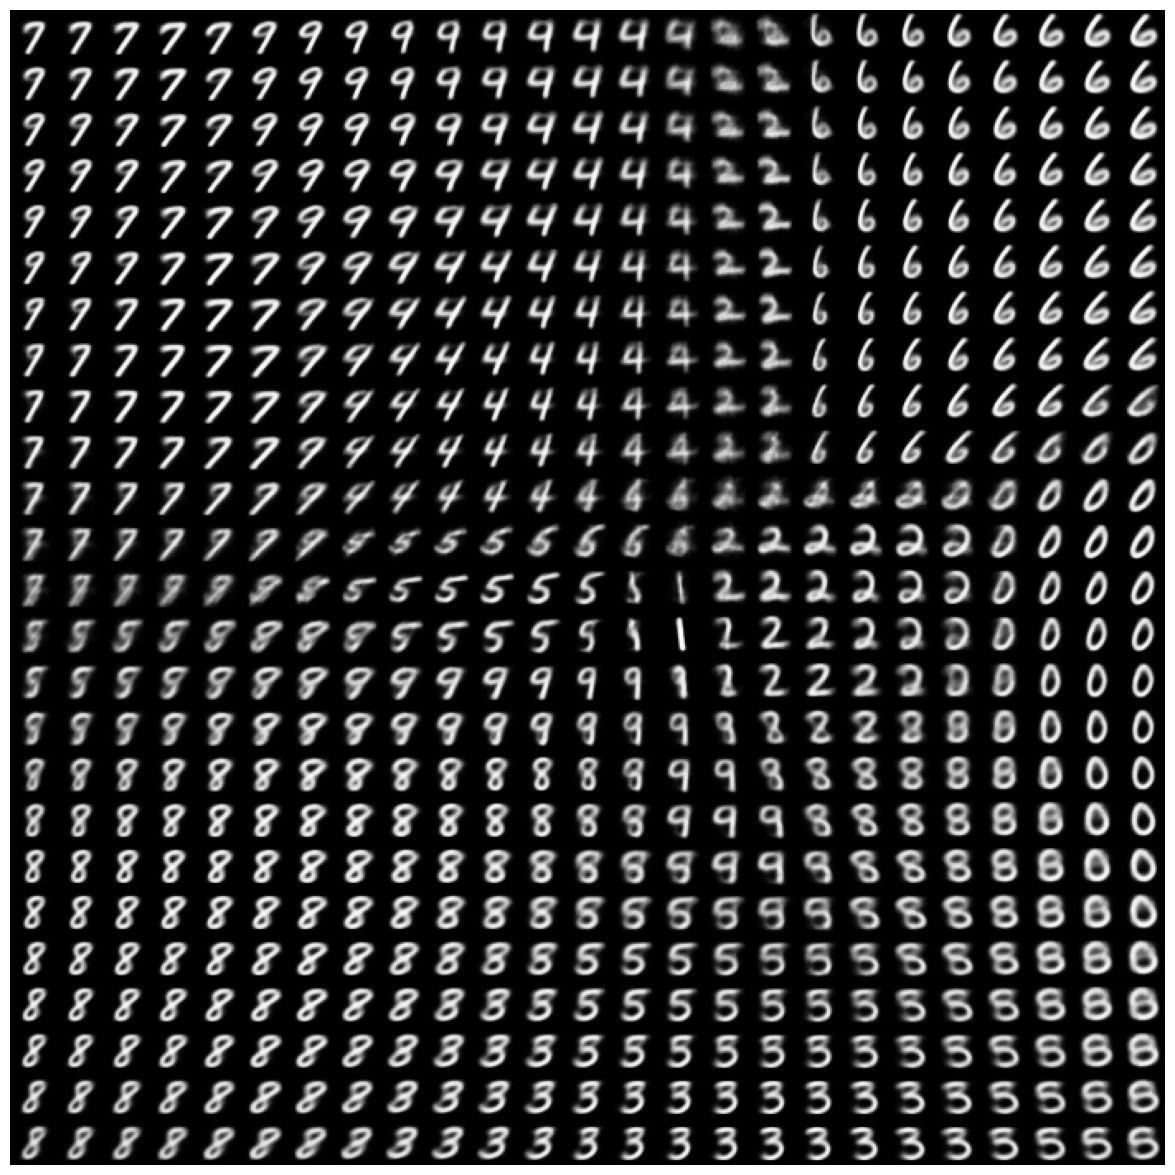

In [37]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*


زمانی که از نواحی خارج از فضای نهان که معمولاً به محدوده [-1, 1] محدود شده‌اند نمونه‌برداری می‌کنیم، با مشکلات زیر مواجه خواهیم شد:

1. عدم آشنایی با داده‌ها:

   • مدل برای نقشه‌برداری از مقادیر فضای نهان در محدوده مشخصی آموزش دیده است. بنابراین، وقتی از نواحی خارج از این محدوده نمونه‌برداری می‌کنیم (مثلاً [-3, 3])، به مناطقی می‌رویم که مدل در طول آموزش به خوبی آن‌ها را بررسی نکرده است.

2. خروجی‌های بی‌معنا یا مبهم:

   • در این نواحی، دکودر ممکن است تصاویر بی‌معنا یا مبهمی تولید کند زیرا نمایه‌های نهان در این نواحی به خوبی یادگیری نشده‌اند. هر چه فاصله ما از ناحیه‌ای که VAE بر روی آن آموزش دیده بیشتر شود، عدم قطعیت دکودر در تولید نوع تصویر مناسب بیشتر می‌شود و منجر به خروجی‌های نامناسب یا تصادفی خواهد شد.

اگر به جای VAE از یک Autoencoder ساده استفاده کنیم، نتایج متفاوت خواهد بود:

1. عدم نظم در فضای نهان:

   • در یک Autoencoder ساده، فضای نهان به پیروی از توزیع خاصی (مانند توزیع نرمال در VAE) مجبور نیست. این باعث می‌شود که فضای نهان ممکن است بسیار پراکنده و غیرمتصل باشد. برخی نواحی ممکن است اصلاً به اعداد معتبر مربوط نباشند.

2. خروجی‌های بی‌معنا:

   • اگر از نواحی خارج از فضای یادگرفته شده نمونه‌برداری کنیم، احتمالاً خروجی‌هایی بی‌معنا یا تصادفی دریافت خواهیم کرد، زیرا هیچ محدودیتی وجود ندارد که انتقالات هموار بین نمایه‌های فضای نهان را تضمین کند.
در مقایسه، VAE با ایجاد یک فضای نهان هموار و منظم، حتی اگر از نواحی غیرمورد بازدید نمونه‌برداری شود، می‌تواند نتایج معناداری تولید کند (هرچند که ممکن است کمتر دقیق باشند). در حالی که Autoencoder ساده به دلیل عدم وجود چنین نظمی، احتمالاً خروجی‌های بی‌معناتر و غیرقابل پیش‌بینی‌تری تولید می‌کند.